In [57]:
import pandas as pd

# Creating the DataFrame from the provided data
data = {
    "v": [780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220],
    "n1": [0, 198, 872, 984, 1000, 1035, 1041, 1076, 1079, 1056, 1069, 1074, 1137, 1059, 1164, 1131, 1122, 1207, 1244, 1209, 1285, 1322, 2030],
    "n2": [0, 195, 865, 970, 1014, 1031, 1041, 1061, 1061, 1040, 1114, 1138, 1087, 1122, 1168, 1149, 1213, 1215, 1243, 1256, 1260, 1334, 2031],
    "n3": [0, 202, 892, 983, 1002, 1037, 1047, 1064, 1102, 1125, 1101, 1110, 1138, 1156, 1165, 1148, 1256, 1203, 1240, 1234, 1223, 1347, 2036]
}

df = pd.DataFrame(data)

# Calculating n_sum and count_rate
df['n_sum'] = (df['n1'] + df['n2'] + df['n3']) / 3
df['n_sum'] = df['n_sum']
df['count_rate'] = df['n_sum'] / 30

# Displaying the DataFrame
print(df)


       v    n1    n2    n3        n_sum  count_rate
0    780     0     0     0     0.000000    0.000000
1    800   198   195   202   198.333333    6.611111
2    820   872   865   892   876.333333   29.211111
3    840   984   970   983   979.000000   32.633333
4    860  1000  1014  1002  1005.333333   33.511111
5    880  1035  1031  1037  1034.333333   34.477778
6    900  1041  1041  1047  1043.000000   34.766667
7    920  1076  1061  1064  1067.000000   35.566667
8    940  1079  1061  1102  1080.666667   36.022222
9    960  1056  1040  1125  1073.666667   35.788889
10   980  1069  1114  1101  1094.666667   36.488889
11  1000  1074  1138  1110  1107.333333   36.911111
12  1020  1137  1087  1138  1120.666667   37.355556
13  1040  1059  1122  1156  1112.333333   37.077778
14  1060  1164  1168  1165  1165.666667   38.855556
15  1080  1131  1149  1148  1142.666667   38.088889
16  1100  1122  1213  1256  1197.000000   39.900000
17  1120  1207  1215  1203  1208.333333   40.277778
18  1140  12

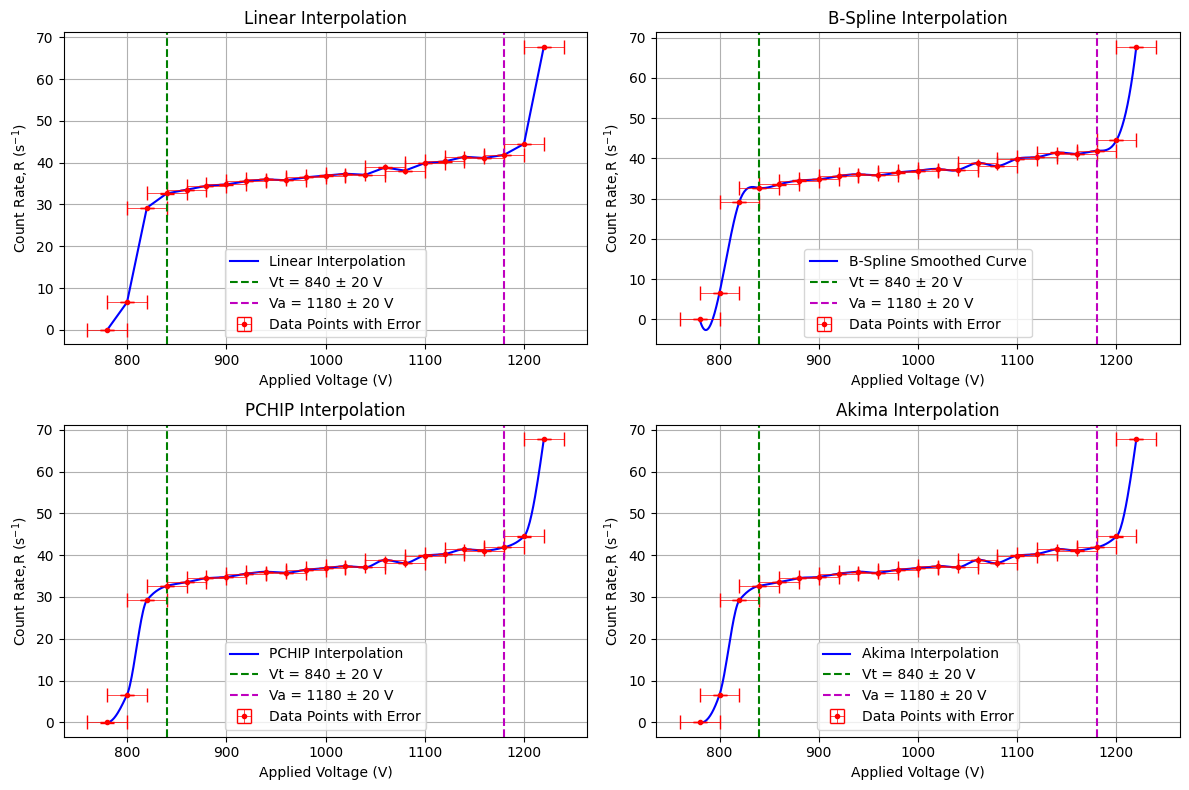

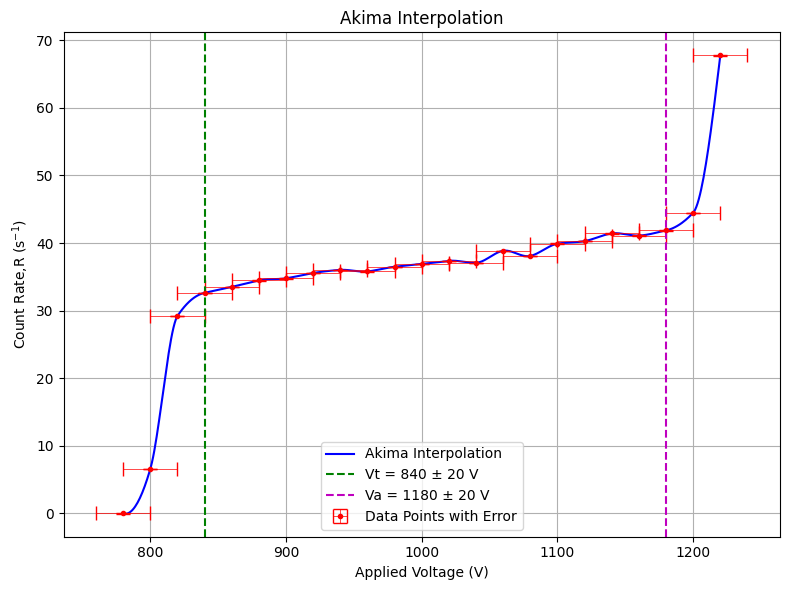

Starting Voltage: 780 V
Threshold Voltage (V_t): 840 ± 20 V, Count Rate (R_t): 32.63 ± 0.03 1/s
Breakdown Voltage (V_a): 1180 ± 20 V, Count Rate (R_a): 41.87 ± 0.03 1/s
Operating Voltage: 1010 V
Slope of the Geiger plateau: 0.07% per volt
Percentage discrepancy between standard value (0.1% per volt) and experimental value: 27.10%


In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, splrep, splev, Akima1DInterpolator, PchipInterpolator

# Data from the image
v = np.array([780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220])
rate = np.array([0, 6.61111111, 29.2111111, 32.6333333, 33.5111111, 34.4777778, 34.7777778, 35.5666667, 36.0222222, 35.7888889, 36.4888889, 36.9111111, 
                 37.3555556, 37.0777778, 38.8555556, 38.0888889, 39.9, 40.2777778, 41.4111111, 41.1, 41.8666667, 44.4777778, 67.7444444])

# Error specifications
v_err = np.full_like(v, 20)  # Error of voltage is 20V
rate_err = np.full_like(rate, 0.03)  # Error of counting rate is 0.03

# Create a range of values for a smooth curve
v_smooth = np.linspace(v.min(), v.max(), 500)

# Linear Interpolation
linear_interp = interp1d(v, rate)
rate_smooth_linear = linear_interp(v_smooth)

# B-Spline Interpolation
spl = splrep(v, rate)
rate_smooth_bspline = splev(v_smooth, spl)

# PCHIP Interpolation
pchip_interp = PchipInterpolator(v, rate)
rate_smooth_pchip = pchip_interp(v_smooth)

# Akima Interpolation
akima_interp = Akima1DInterpolator(v, rate)
rate_smooth_akima = akima_interp(v_smooth)

def compute_geiger_plateau_slope(v, rate):
    # Calculate gradient
    gradients = np.gradient(rate, v)
    
    # Calculate the second derivative (change in gradients)
    second_gradients = np.gradient(gradients, v)
    
    # Identify the threshold voltage (V_t) where the gradient suddenly decreases to a small value
    V_t_index = np.argmin(second_gradients)
    V_t_index_real = V_t_index + 1  # Adjust to the next point after the minimum gradient
    
    # Identify the breakdown voltage (V_a) where the gradient suddenly increases to a large value
    V_a_index = np.argmax(second_gradients)
    V_a_index_real = V_a_index - 1  # Adjust to the point before the maximum gradient
    
    V_t = v[V_t_index_real]
    V_a = v[V_a_index_real]
    R_t = rate[V_t_index_real]
    R_a = rate[V_a_index_real]
    
    # Compute the slope using the given formula
    slope = ((R_a - R_t) / (0.5 * (R_a + R_t) * (V_a - V_t))) * 100
    
    return slope, V_t, V_a, R_t, R_a, V_t_index_real, V_a_index_real

# Compute the slope of the Geiger plateau
slope, V_t, V_a, R_t, R_a, V_t_index_real, V_a_index_real = compute_geiger_plateau_slope(v, rate)

# Calculate operating voltage
V_operating = (V_t + V_a) / 2
V_start = v[0]  # Starting voltage

# Plotting all data in one figure
plt.figure(figsize=(12, 8))

# Linear Interpolation
plt.subplot(2, 2, 1)
plt.plot(v_smooth, rate_smooth_linear, color='b', label='Linear Interpolation')
plt.errorbar(v, rate, xerr=v_err, yerr=rate_err, fmt='r.', label='Data Points with Error', capsize=5, linewidth=0.5)
plt.axvline(V_t, color='g', linestyle='--', label=f'Vt = {V_t} ± {v_err[V_t_index_real]} V')
plt.axvline(V_a, color='m', linestyle='--', label=f'Va = {V_a} ± {v_err[V_a_index_real]} V')
plt.title('Linear Interpolation')
plt.xlabel('Applied Voltage (V)')
plt.ylabel('Count Rate,R (s$^{-1}$)')
plt.legend()
plt.grid(True)

# B-Spline Interpolation
plt.subplot(2, 2, 2)
plt.plot(v_smooth, rate_smooth_bspline, color='b', label='B-Spline Smoothed Curve')
plt.errorbar(v, rate, xerr=v_err, yerr=rate_err, fmt='r.', label='Data Points with Error', capsize=5, linewidth=0.5)
plt.axvline(V_t, color='g', linestyle='--', label=f'Vt = {V_t} ± {v_err[V_t_index_real]} V')
plt.axvline(V_a, color='m', linestyle='--', label=f'Va = {V_a} ± {v_err[V_a_index_real]} V')
plt.title('B-Spline Interpolation')
plt.xlabel('Applied Voltage (V)')
plt.ylabel('Count Rate,R (s$^{-1}$)')
plt.legend()
plt.grid(True)

# PCHIP Interpolation
plt.subplot(2, 2, 3)
plt.plot(v_smooth, rate_smooth_pchip, color='b', label='PCHIP Interpolation')
plt.errorbar(v, rate, xerr=v_err, yerr=rate_err, fmt='r.', label='Data Points with Error', capsize=5, linewidth=0.5)
plt.axvline(V_t, color='g', linestyle='--', label=f'Vt = {V_t} ± {v_err[V_t_index_real]} V')
plt.axvline(V_a, color='m', linestyle='--', label=f'Va = {V_a} ± {v_err[V_a_index_real]} V')
plt.title('PCHIP Interpolation')
plt.xlabel('Applied Voltage (V)')
plt.ylabel('Count Rate,R (s$^{-1}$)')
plt.legend()
plt.grid(True)

# Akima Interpolation
plt.subplot(2, 2, 4)
plt.plot(v_smooth, rate_smooth_akima, color='b', label='Akima Interpolation')
plt.errorbar(v, rate, xerr=v_err, yerr=rate_err, fmt='r.', label='Data Points with Error', capsize=5, linewidth=0.5)
plt.axvline(V_t, color='g', linestyle='--', label=f'Vt = {V_t} ± {v_err[V_t_index_real]} V')
plt.axvline(V_a, color='m', linestyle='--', label=f'Va = {V_a} ± {v_err[V_a_index_real]} V')
plt.title('Akima Interpolation')
plt.xlabel('Applied Voltage (V)')
plt.ylabel('Count Rate,R (s$^{-1}$)')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Separate plot for Akima Interpolation
plt.figure(figsize=(8, 6))
plt.plot(v_smooth, rate_smooth_akima, color='b', label='Akima Interpolation')
plt.errorbar(v, rate, xerr=v_err, yerr=rate_err, fmt='r.', label='Data Points with Error', capsize=5, linewidth=0.5)
plt.axvline(V_t, color='g', linestyle='--', label=f'Vt = {V_t} ± {v_err[V_t_index_real]} V')
plt.axvline(V_a, color='m', linestyle='--', label=f'Va = {V_a} ± {v_err[V_a_index_real]} V')
plt.title('Akima Interpolation')
plt.xlabel('Applied Voltage (V)')
plt.ylabel('Count Rate,R (s$^{-1}$)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compute the percentage difference between the standard value and the experimental value
standard_slope = 0.1  # standard slope value in % per volt
percentage_discrepancy = abs((slope - standard_slope) / standard_slope) * 100

print(f"Starting Voltage: {V_start} V")
print(f"Threshold Voltage (V_t): {V_t} ± {v_err[V_t_index_real]} V, Count Rate (R_t): {R_t:.2f} ± {rate_err[V_t_index_real]} 1/s")
print(f"Breakdown Voltage (V_a): {V_a} ± {v_err[V_a_index_real]} V, Count Rate (R_a): {R_a:.2f} ± {rate_err[V_a_index_real]} 1/s")
print(f"Operating Voltage: {V_operating:.0f} V")
print(f"Slope of the Geiger plateau: {slope:.2f}% per volt")
print(f"Percentage discrepancy between standard value (0.1% per volt) and experimental value: {percentage_discrepancy:.2f}%")
